In [1]:
## Import relevant libraries
import sys
import os
import shutil
from natsort import natsorted  # For natural sorting
sys.path.append('../../activedrops')

## Including ourselves
import quadrop as qd
qd.set_plotting_style()

import glob
import imageio
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [2]:
data_path = "../../data/040224-calibration-yfp/pos0_2mgml_3/"

# let's declare the variable "conditions" to the sorted list of subdirectories from data_path
conditions = natsorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])

# let's declare the variable "subconditions" to the sorted list of subdirectories from the first condition
subconditions = natsorted([f for f in os.listdir(os.path.join(data_path, conditions[0])) if os.path.isdir(os.path.join(data_path, conditions[0], f))])



In [3]:
qd.reorgTiffsToOriginal(data_path, conditions, subconditions)

Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos24 to ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos24/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos25 to ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos25/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos26 to ../../data/040224-calibration-yfp/pos0_2mgml_3/0ugml/Pos26/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos24 to ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos24/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos25 to ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos25/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos26 to ../../data/040224-calibration-yfp/pos0_2mgml_3/2ugml/Pos26/original
Moved .tif files from ../../data/040224-calibration-yfp/pos0_2mgml_3/5ugml/Pos24 to ../.

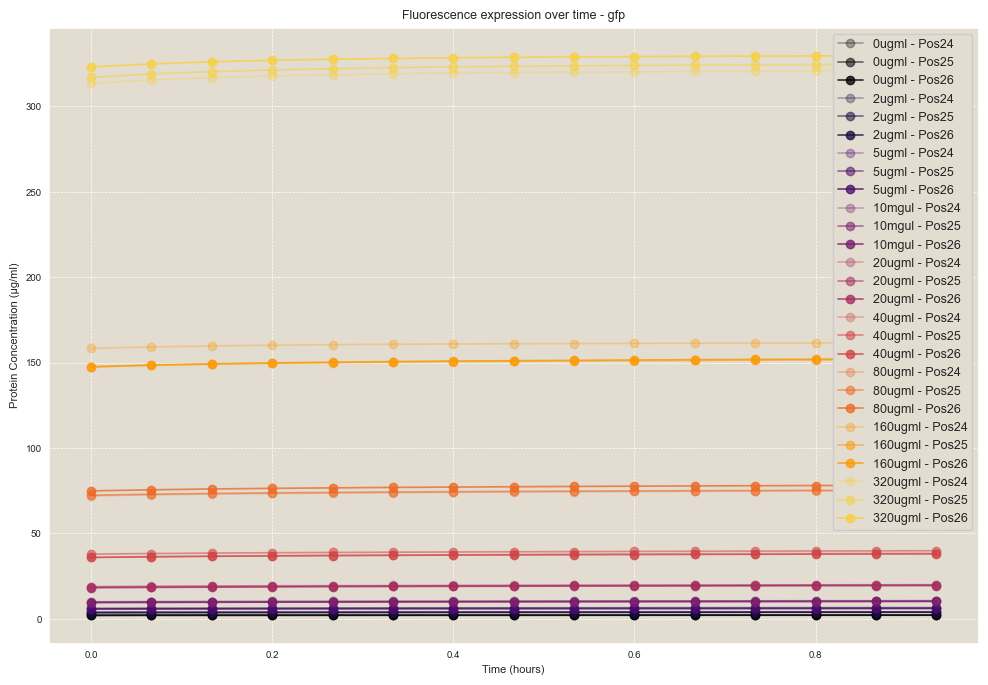

In [4]:
# channel info
channel = "gfp"
min_frame = 0
max_frame = None
skip_frames=4
frame_rate=30
time_intervals = [60] * len(conditions)

# Call the function with the updated parameters
qd.plot_fluorescence(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel=channel,
    time_intervals=time_intervals,  
    min_frame=min_frame,
    max_frame=max_frame,
    skip_frames=skip_frames,
    log_scale=False,  # Set log_scale to True
    timescale="h",
    averaged=False
)

In [5]:
def average_intensity_per_condition(data_path, conditions, subconditions, channel):
    """
    Computes and returns a table of the average of the average fluorescence intensity for each condition,
    with a separate column for concentration in µg/ml.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel name (e.g., "cy5", "gfp").
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['concentration µg/ml', 'average_intensity'].
    """
    average_intensities = []
    
    for condition in conditions:
        # Parse out the numeric part of the condition and convert to an integer
        concentration = int(''.join(filter(str.isdigit, condition)))
        
        condition_intensities = []
        for subcondition in subconditions:
            directory_path = os.path.join(data_path, condition, subcondition, "original")
            
            if channel == "cy5":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*cy5-4x_000.tif")))
            elif channel == "gfp":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*gfp-4x_000.tif")))
            
            intensities = []
            
            for image_file in image_files:
                img = imageio.imread(image_file) / 2**16
                mean_intensity = np.mean(img)
                intensities.append(mean_intensity)
            
            if intensities:  # Ensure there are intensities to average
                average_intensity = np.mean(intensities)
                condition_intensities.append(average_intensity)
        
        if condition_intensities:  # Ensure there are condition intensities to average
            condition_avg_intensity = np.mean(condition_intensities)
            average_intensities.append({
                "concentration µg/ml": concentration,
                "average_intensity": condition_avg_intensity
            })
    
    # Create DataFrame
    df = pd.DataFrame(average_intensities)
    # Sort by concentration just in case the input conditions were not in order
    df = df.sort_values(by="concentration µg/ml").reset_index(drop=True)
    
    return df


df = average_intensity_per_condition(data_path, conditions, subconditions, channel)
df

/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_49087/2000083332.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_file) / 2**16


,concentration µg/ml,average_intensity
0,0,0.002686
1,2,0.002876
2,5,0.002930
3,10,0.002976
4,20,0.003036
5,40,0.003312
6,80,0.017919
7,160,0.066385
8,320,0.150386


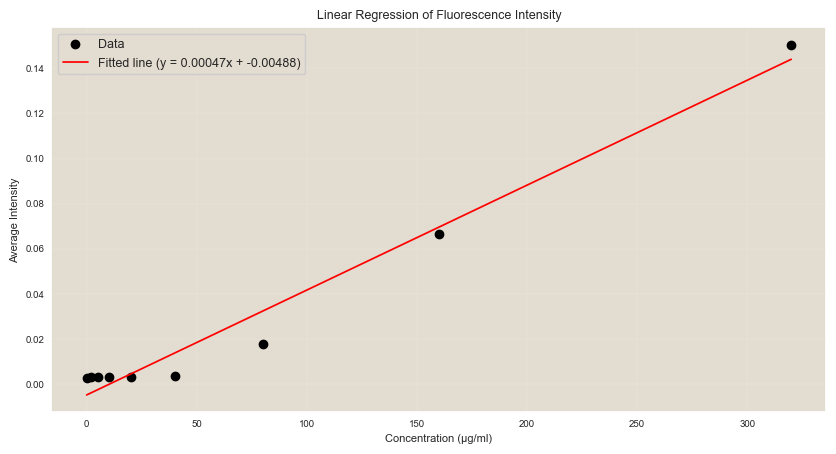

(0.00046531621946608676, -0.004877933875179076)

In [6]:
# Function to perform linear regression and plot the data along with the fitted line
def linear_regression_with_plot(df):
    # Reshape the data to fit sklearn's expected format
    X = df['concentration µg/ml'].values.reshape(-1, 1)
    y = df['average_intensity'].values
    
    # Create and fit the model
    model = LinearRegression().fit(X, y)
    
    # Coefficients
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predicted values
    y_pred = model.predict(X)
    
    # Plotting the original data and the regression line
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, label='Data', color='black')
    plt.plot(X, y_pred, label=f'Fitted line (y = {slope:.5f}x + {intercept:.5f})', color='red')
    plt.title('Linear Regression of Fluorescence Intensity')
    plt.xlabel('Concentration (µg/ml)')
    plt.ylabel('Average Intensity')
    plt.legend()
    plt.show()
    
    return slope, intercept

# Assuming 'df' is the DataFrame provided earlier with concentration and average_intensity
slope, intercept = linear_regression_with_plot(df)

# Output the equation of the line
(slope, intercept)
